Image Preprocessing 

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os
import random
from glob import glob
from sklearn.model_selection import train_test_split
from PIL import Image
from pathlib import Path

In [27]:
# ===============================
# Cell 2: Load paths and labels
# ===============================
data_dir = "./dataset"   
classes = ["normal", "osteoporosis"]

all_image_paths = []
all_labels = []
for idx, cls in enumerate(classes):
    paths = glob(os.path.join(data_dir, cls, "*"))
    all_image_paths.extend(paths)
    all_labels.extend([idx]*len(paths))

all_image_paths = np.array(all_image_paths)
all_labels = np.array(all_labels)

print("Total images:", len(all_image_paths))

Total images: 372


In [28]:
# Cell 3: Inspect dataset and collect filepaths & labels
classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
class_to_index = {c:i for i,c in enumerate(classes)}
print("Classes:", classes)

filepaths = []
labels = []
for cls in classes:
    cls_dir = os.path.join(data_dir, cls)
    files = sorted(glob(os.path.join(cls_dir, "*")))
    print(f"Found {len(files)} images in {cls}")
    for f in files:
        filepaths.append(os.path.abspath(f))
        labels.append(class_to_index[cls])

filepaths = np.array(filepaths)
labels = np.array(labels)
print("Total images:", len(filepaths))


Classes: ['normal', 'osteoporosis']
Found 186 images in normal
Found 186 images in osteoporosis
Total images: 372


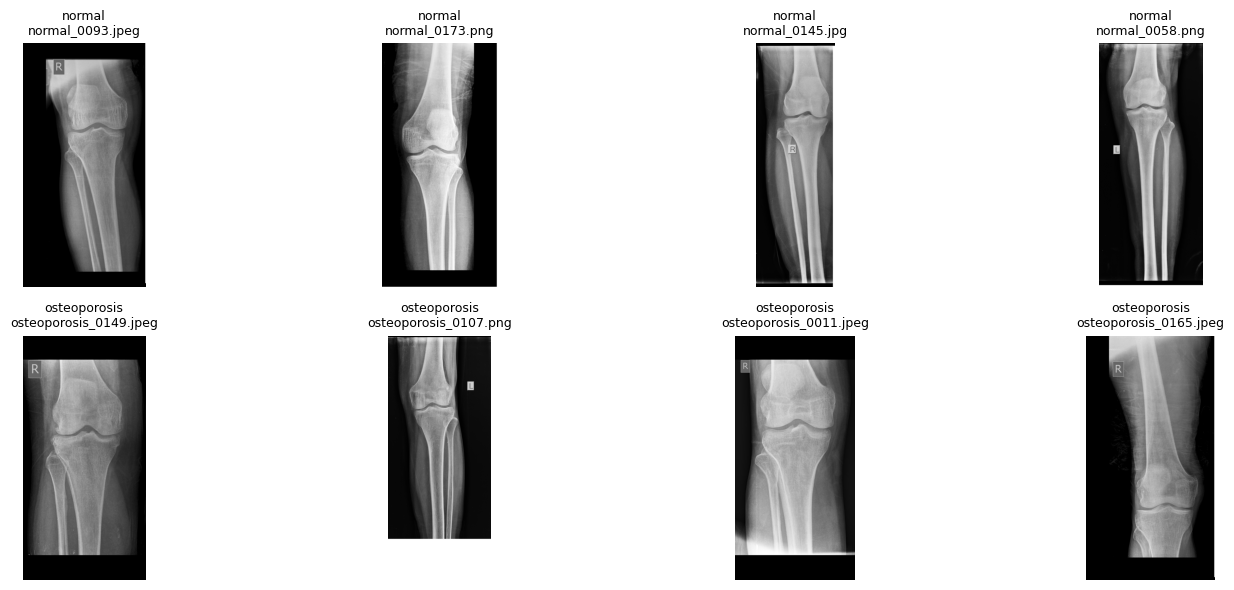

In [30]:
# Cell 5: Visualize 4 images per class
def show_samples(base_dir, classes, n_per_class=4):
    plt.figure(figsize=(4*n_per_class, 6))
    for i, cls in enumerate(classes):
        files = sorted(glob(os.path.join(base_dir, cls, "*")))
        random.shuffle(files)
        files = files[:n_per_class]
        for j, fp in enumerate(files):
            ax = plt.subplot(len(classes), n_per_class, i*n_per_class + j + 1)
            img = Image.open(fp).convert("RGB")
            plt.imshow(img)
            ax.set_title(f"{cls}\n{Path(fp).name}", fontsize=9)
            ax.axis("off")
    plt.tight_layout()
    plt.show()

show_samples(data_dir, classes, n_per_class=4)


In [31]:
# ===============================
# Cell 3: Split data
# ===============================
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    all_image_paths, all_labels, stratify=all_labels, test_size=0.3, random_state=42
)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, stratify=temp_labels, test_size=0.5, random_state=42
)

print(f"Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")


Train: 260, Val: 56, Test: 56


In [34]:
# ==============================================================
# 📌 PIPELINE 1 & 2 Setup
# ==============================================================

IMG_SIZE = (224, 224)

# --- PIPELINE 1: Raw Images ---
def preprocess_1(path, label):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=1)      # grayscale
    img = tf.image.resize(img, IMG_SIZE)          # resize
    img = tf.image.grayscale_to_rgb(img)          # convert to RGB for pretrained models
    return img, label

# --- PIPELINE 2: Normalization (MobileNetV2 preprocess) ---
def preprocess_2(path, label):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=1)      # grayscale
    img = tf.image.resize(img, IMG_SIZE)          # resize
    img = tf.image.grayscale_to_rgb(img)          # convert to RGB
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)  # normalize
    return img, label


# --- Generic Dataset Builder ---
def make_dataset(paths, labels, batch_size=16, shuffle=True, pipeline=1):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    if pipeline == 1:
        ds = ds.map(preprocess_1, num_parallel_calls=tf.data.AUTOTUNE)
    elif pipeline == 2:
        ds = ds.map(preprocess_2, num_parallel_calls=tf.data.AUTOTUNE)
    # in future you can add: elif pipeline==3: preprocess_3 ...

    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths))

    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds


In [35]:
# --- Create Datasets for Pipeline 1 (Raw Images) ---
train_ds_1 = make_dataset(train_paths, train_labels, batch_size=16, pipeline=1)
val_ds_1   = make_dataset(val_paths, val_labels, batch_size=16, shuffle=False, pipeline=1)
test_ds_1  = make_dataset(test_paths, test_labels, batch_size=16, shuffle=False, pipeline=1)

# --- Create Datasets for Pipeline 2 (Normalized) ---
train_ds_2 = make_dataset(train_paths, train_labels, batch_size=16, pipeline=2)
val_ds_2   = make_dataset(val_paths, val_labels, batch_size=16, shuffle=False, pipeline=2)
test_ds_2  = make_dataset(test_paths, test_labels, batch_size=16, shuffle=False, pipeline=2)

In [37]:
# Model
base_model_1 = tf.keras.applications.MobileNetV2(
    weights="imagenet", include_top=False, input_shape=(224,224,3)
)
base_model_1.trainable = False

model_1 = tf.keras.Sequential([
    base_model_1,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_1.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [38]:
print("\nTraining PIPELINE 1 (Raw Images)...\n")
history_1 = model_1.fit(train_ds_1, validation_data=val_ds_1, epochs=10)


Training PIPELINE 1 (Raw Images)...

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 659ms/step - accuracy: 0.4654 - loss: 0.8392 - val_accuracy: 0.5714 - val_loss: 0.6862
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 485ms/step - accuracy: 0.4808 - loss: 0.7775 - val_accuracy: 0.5714 - val_loss: 0.6656
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 520ms/step - accuracy: 0.5462 - loss: 0.7512 - val_accuracy: 0.5714 - val_loss: 0.6488
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 481ms/step - accuracy: 0.5615 - loss: 0.7476 - val_accuracy: 0.6250 - val_loss: 0.6352
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 448ms/step - accuracy: 0.5308 - loss: 0.7283 - val_accuracy: 0.7143 - val_loss: 0.6215
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 488ms/step - accuracy: 0.5423 - loss: 0.7069 - val_accuracy: 0.7143 - val_loss: 0.6104
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 451ms/step - accuracy: 0.5654 - loss: 0.7015 - val_accuracy: 0.6964 - val_loss: 0.5989
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 468ms/step - accurac

In [39]:
# Model
base_model_2 = tf.keras.applications.MobileNetV2(
    weights="imagenet", include_top=False, input_shape=(224,224,3)
)
base_model_2.trainable = False

model_2 = tf.keras.Sequential([
    base_model_2,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_2.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [40]:
print("\nTraining PIPELINE 2 (Normalization Only)...\n")
history_2 = model_2.fit(train_ds_2, validation_data=val_ds_2, epochs=10)


Training PIPELINE 2 (Normalization Only)...

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 570ms/step - accuracy: 0.5500 - loss: 0.8803 - val_accuracy: 0.5357 - val_loss: 0.8209
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 749ms/step - accuracy: 0.5115 - loss: 0.7878 - val_accuracy: 0.6071 - val_loss: 0.7073
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 587ms/step - accuracy: 0.5731 - loss: 0.6916 - val_accuracy: 0.6250 - val_loss: 0.6671
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 464ms/step - accuracy: 0.5923 - loss: 0.7088 - val_accuracy: 0.6786 - val_loss: 0.6503
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 521ms/step - accuracy: 0.6462 - loss: 0.6410 - val_accuracy: 0.6786 - val_loss: 0.6395
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 553ms/step - accuracy: 0.6269 - loss: 0.6615 - val_accuracy: 0.6964 - val_loss: 0.6286
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 585ms/step - accuracy: 0.6115 - loss: 0.6876 - val_accuracy: 0.6964 - val_loss: 0.6239
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 501ms/ste

In [41]:
# ==============================================================
# 📌 Evaluation Helper
# ==============================================================

def evaluate_and_report(model, dataset, split_name="Validation"):
    y_true, y_pred = [], []
    for imgs, lbls in dataset:
        preds = model.predict(imgs, verbose=0)
        y_true.extend(lbls.numpy())
        y_pred.extend((preds > 0.5).astype("int32").flatten())

    print(f"\n{split_name} -> Accuracy:", np.mean(np.array(y_true) == np.array(y_pred)))
    print(classification_report(y_true, y_pred, target_names=classes))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.title(f"{split_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


EVALUATION: PIPELINE 1 (Raw Images)

Validation -> Accuracy: 0.6964285714285714
              precision    recall  f1-score   support

      normal       0.69      0.71      0.70        28
osteoporosis       0.70      0.68      0.69        28

    accuracy                           0.70        56
   macro avg       0.70      0.70      0.70        56
weighted avg       0.70      0.70      0.70        56



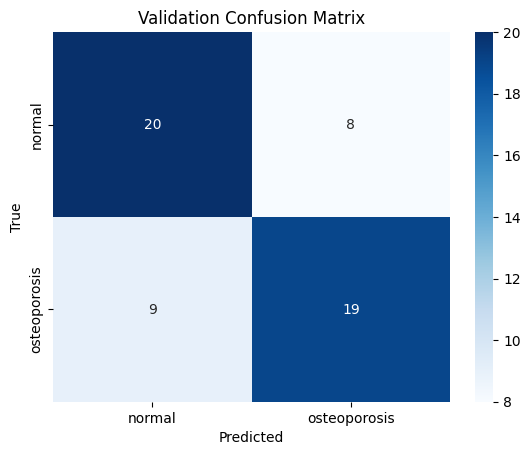


Test -> Accuracy: 0.75
              precision    recall  f1-score   support

      normal       0.75      0.75      0.75        28
osteoporosis       0.75      0.75      0.75        28

    accuracy                           0.75        56
   macro avg       0.75      0.75      0.75        56
weighted avg       0.75      0.75      0.75        56



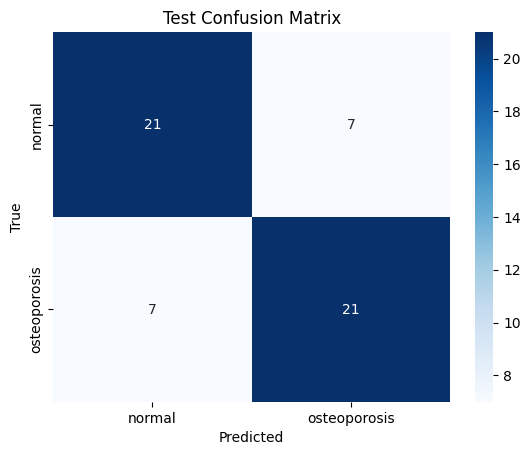


EVALUATION: PIPELINE 2 (Normalization Only)

Validation -> Accuracy: 0.7321428571428571
              precision    recall  f1-score   support

      normal       0.84      0.57      0.68        28
osteoporosis       0.68      0.89      0.77        28

    accuracy                           0.73        56
   macro avg       0.76      0.73      0.73        56
weighted avg       0.76      0.73      0.73        56



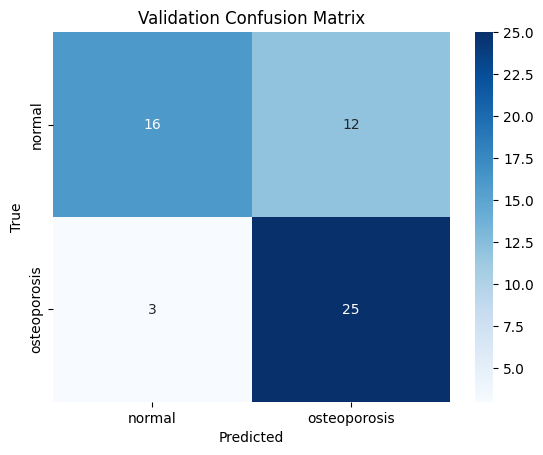


Test -> Accuracy: 0.7321428571428571
              precision    recall  f1-score   support

      normal       0.78      0.64      0.71        28
osteoporosis       0.70      0.82      0.75        28

    accuracy                           0.73        56
   macro avg       0.74      0.73      0.73        56
weighted avg       0.74      0.73      0.73        56



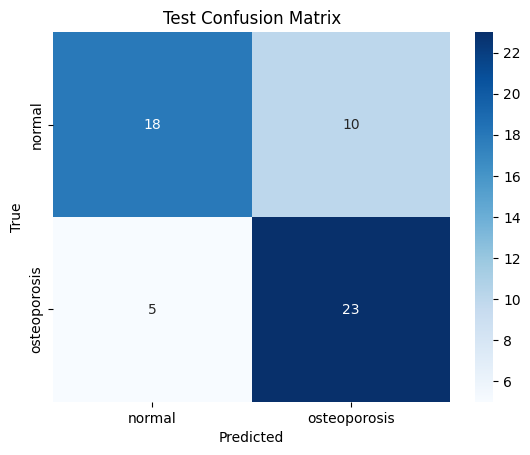

In [ ]:
# ===============================
# 📌 Evaluate Both Pipelines
# ===============================
print("\nEVALUATION: PIPELINE 1 (Raw Images)")
evaluate_and_report(model_1, train_ds_1, "Train")
evaluate_and_report(model_1, val_ds_1, "Validation")
evaluate_and_report(model_1, test_ds_1, "Test")

print("\nEVALUATION: PIPELINE 2 (Normalization Only)")
evaluate_and_report(model_2, val_ds_2, "Validation")
evaluate_and_report(model_2, test_ds_2, "Test")